
# DINOv3 → Fastai Regression Head (Valence–Arousal)

This notebook shows how to **freeze a DINOv3 backbone** (from 🤗 Transformers) and train a **small regression head** in **fastai** for **valence–arousal (V-A)** prediction.

- Targets are expected in **FindingEmo** units: **V∈[-3,3]**, **A∈[0,6]**.  
- For training we map to a bipolar space: **v_ref = v/3**, **a_ref = (a−3)/3** → both in **[-1,1]**.  
- We report **MAE**, **CCC**, and **Spearman’s ρ** on the test set.  
- Backbone remains **frozen**; only the tiny head trains.

In [1]:
# --- Install latest libraries (uncomment if needed) ---
# %pip install -U torch torchvision torchaudio
# %pip install -U fastai transformers timm torchmetrics datasets
# %pip install -U accelerate
#
# If you're on Apple Silicon and want MPS acceleration, make sure your PyTorch build supports MPS.
# See: https://pytorch.org/get-started/locally/


# Import Libs

In [2]:
from __future__ import annotations

import os, math, random, shutil, json
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import math

# Fastai
from fastai.vision.all import *
from fastai.learner import load_learner
from fastai.callback.tracker import CSVLogger

from PIL import Image, ImageOps

# Transformers
from transformers import AutoImageProcessor, AutoModel

# Metrics
from torchmetrics.functional.regression import concordance_corrcoef as ccc_fn
# (Spearman is computed later in the test block)

# Device (prefers Apple MPS on M-series Macs)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_float32_matmul_precision("high")
device


device(type='mps')

In [3]:
# Load environment variables
from dotenv import load_dotenv

load_dotenv()

# Set HuggingFace token for authentication
if "HUGGINGFACE_TOKEN" in os.environ:
    from huggingface_hub import login

    login(token=os.environ["HUGGINGFACE_TOKEN"])

# Config

In [ ]:
MODEL_NAME = "facebook/dinov3-vitb16-pretrain-lvd1689m"  # you can switch to vits16/vitsplus/vit7b16, etc.
IMAGE_SIZE = 608
BATCH_SIZE = 32
NUM_WORKERS = 8
EPOCHS = 10

# Use only a fraction of the dataset for faster experiments
DATA_FRACTION = 1  # Only downsamples Training Data
SAMPLE_SEED = 2025

DATA_ROOT = Path("../../data")  # FindingEmo dataset root
CSV_TRAIN = Path(
    "../../data/train_clean.csv"
)  # CSV with columns: image_path,valence,arousal
CSV_VALID = Path("../../data/valid_clean.csv")  # Validation split
CSV_TEST = Path("../../data/test_clean.csv")  # Test split


# Load DINOv3 Processor + Backbone

In [5]:
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME)

# Freeze backbone
for p in backbone.parameters():
    p.requires_grad = False

backbone = backbone.to(device)
backbone.eval()

# Infer feature dim for the pooled output
with torch.inference_mode():
    # Create a single dummy image tensor with processor's expected size
    dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE, dtype=torch.float32)
    out = backbone(pixel_values=dummy.to(device))
    feat_dim = None
    if hasattr(out, "pooler_output") and (out.pooler_output is not None):
        feat_dim = out.pooler_output.shape[-1]
    else:
        # Fallback: ViT CLS token (last_hidden_state[:, 0, :]) or spatial mean for ConvNext-like
        if hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 3:
            feat_dim = out.last_hidden_state.shape[-1]
        elif hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 4:
            feat_dim = out.last_hidden_state.shape[1]
        else:
            raise RuntimeError("Unable to determine DINOv3 feature dimension.")
feat_dim


768

## Why Change Scale?


+ Balanced targets: Valence is −3..3 and Arousal is 0..6. A simple head works best when both targets live on the same bounded range. Mapping both to [-1,1] makes losses comparable and gradients stable.  

+ Match the head: A tanh head naturally outputs [-1,1]. If labels aren’t in that range, the head must learn offsets/scales, which slows learning and can saturate activations.  

+ Stable training with tanh: Using [-1,1] targets with a tanh head avoids saturation and keeps gradients stable, while evaluation is still reported back in FE units.

## How We Scale

+ Forward (to train): v_ref = v / 3 maps −3..3 → −1..1; a_ref = (a − 3) / 3 maps 0..6 → −1..1.  

+ Backward (to report): v = 3·v_ref; a = 3·a_ref + 3.  

+ Head: Adds tanh so predictions are already in [-1,1]. We train with plain MSE on these bipolar targets.


In [6]:
def fe_to_ref(va: Tensor) -> Tensor:
    "Map FindingEmo V∈[-3,3], A∈[0,6] -> bipolar space [-1,1]"
    v = va[..., 0] / 3.0
    a = (va[..., 1] - 3.0) / 3.0
    return torch.stack([v, a], dim=-1)


def ref_to_fe(va_ref: Tensor) -> Tensor:
    "Inverse map: bipolar [-1,1] -> FindingEmo units"
    v = va_ref[..., 0] * 3.0
    a = va_ref[..., 1] * 3.0 + 3.0
    return torch.stack([v, a], dim=-1)


# CCC utilities are included via torchmetrics; training uses MSE,
# and evaluation reports MAE, CCC, and Spearman.


# Load FindingEmo dataset

In [7]:
df_train = pd.read_csv(CSV_TRAIN)
df_valid = pd.read_csv(CSV_VALID)
df_test = pd.read_csv(CSV_TEST)

# Optionally downsample only the TRAIN split to a fraction; keep valid/test full
if DATA_FRACTION is not None and DATA_FRACTION < 1.0:
    df_train = df_train.sample(frac=DATA_FRACTION, random_state=SAMPLE_SEED)

# Show a peek
len(df_train), len(df_valid), len(df_test), df_train.head(2)


(13019,
 2792,
 2785,
                                                                          image_path  \
 0                data/Run_2/Suffering seniors office/MCHGNP5AENH4HA2SURH6AWQ274.jpg   
 1  data/Run_2/Affectionate midlife shopping/0_Destin_Harbor_8298-Copy-1536x1004.jpg   
 
    valence  arousal  
 0        1        4  
 1        1        1  )

## Data Preprocessing

In [8]:
# =======================
# Fastai transform: apply HF processor per item
# Aspect-preserving resize to ~800x600 then pad (letterbox)
# =======================
class HFProcessorTransform(Transform):
    def __init__(self, processor, target_size=(800, 608), pad_color=0):
        # target_size is (W, H) in pixels
        self.processor = processor
        self.target_size = target_size
        self.pad_color = pad_color

    def encodes(self, img: PILImage):
        # Ensure PIL.Image
        pil = img if isinstance(img, Image.Image) else PILImage.create(img)
        target_w, target_h = self.target_size
        w, h = pil.size
        # Scale to fit within target while preserving aspect ratio
        scale = min(target_w / max(1, w), target_h / max(1, h))
        new_w = max(1, int(round(w * scale)))
        new_h = max(1, int(round(h * scale)))
        resized = pil.resize((new_w, new_h), resample=Image.Resampling.BILINEAR)
        # Letterbox pad to target size, centered
        canvas = Image.new("RGB", (target_w, target_h), color=self.pad_color)
        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        canvas.paste(resized, (pad_left, pad_top))
        # Normalize with HF processor only (disable any internal resize/crop if supported)
        try:
            proc = self.processor(
                images=np.array(canvas),
                return_tensors="pt",
                do_resize=False,
                do_center_crop=False,
            )
        except TypeError:
            # Fallback for processors that don't accept control flags
            proc = self.processor(images=np.array(canvas), return_tensors="pt")
        x = proc.pixel_values[0]
        return TensorImage(x)


# Label getter that reads FE units from df and maps to bipolar space [-1,1]
def get_y_ref(row):
    va = torch.tensor([row["valence"], row["arousal"]], dtype=torch.float32)
    return fe_to_ref(va)

## Define DataBlock & DataLoaders

🔹 What are Data Blocks?

+ Definition: The Data Block API in fastai is a declarative pipeline for building datasets. It specifies how raw data is transformed into tensors ready for training.

+ Purpose: It allows you to define:

    + How to get items (e.g., list of image paths, rows from a CSV).

    + How to split data (train/valid/test).

    + How to label data (e.g., from folder name, CSV column).

    + How to apply transforms (augmentations, normalization).

Analogy: Think of it as a blueprint for preparing your dataset. Once defined, you can easily create datasets/loaders from different sources with the same structure.

🔹 What are Data Loaders?

+ Definition: A DataLoader is an iterator that efficiently feeds batches of preprocessed data to your model during training and validation.

+ Responsibilities:

    + Handles batching (mini-batches instead of full dataset).

    + Applies transforms on the fly (e.g., data augmentation).

    + Manages shuffling, parallel processing (using workers), and device transfer (CPU → GPU).

Output: Yields (x_batch, y_batch) tensors to the model.

🔹 Why are they needed?

Deep learning training loops need batches of tensors, but:

+ Raw data (images, text, CSVs) often lives in heterogeneous formats (files, tables, nested folders).

+ Preprocessing needs to be consistent and reproducible (resize, normalize, tokenize).

Efficient training requires:

+ Mini-batching (to fit in GPU memory).

+ Shuffling (to break correlations).

+ Parallel loading (so GPU isn’t waiting for CPU).

+ Transform pipelines (on-the-fly augmentation).

The Data Block + Data Loader system ensures all this happens smoothly.


🔹 Why not just load data directly into models?

If you bypass them and load everything manually, you’d have to:

+ Write your own batching logic.

+ Handle shuffling & splits.

+ Apply augmentations consistently.

+ Manage GPU transfers.

This is error-prone, repetitive, and inefficient. Models expect tensors of shape (batch_size, features, ...), not arbitrary images/text arrays.  

So while it’s technically possible to feed raw NumPy arrays directly, you’d lose:

+ Efficiency (no parallelized preloading).

+ Flexibility (hard to switch datasets/splits).

+ Reusability (need to rewrite data logic every project).

+ Integration with training loops, metrics, and fastai callbacks.

In [9]:
# Compute target dims near 800x600, snapped to ViT patch size if available
BASE_W, BASE_H = 800, 600
patch = getattr(getattr(backbone, "config", None), "patch_size", None)
if patch is None:
    # Some configs nest it under patches.size (e.g., DeiT)
    patch = getattr(
        getattr(getattr(backbone, "config", None), "patches", None), "size", None
    )
if isinstance(patch, (list, tuple)) and len(patch) > 0:
    patch = patch[0]
if patch is None:
    patch = 16  # default to ViT-B/16 (DINOv3)
W = int(round(BASE_W / patch) * patch)
H = int(round(BASE_H / patch) * patch)


def df_to_dls(df_train, df_valid, bs=BATCH_SIZE, num_workers=NUM_WORKERS):
    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock(n_out=2)),
        # Prefix paths with project root relative to this notebook (../)
        get_x=ColReader("image_path", pref="../"),
        get_y=get_y_ref,
        item_tfms=[HFProcessorTransform(processor, target_size=(W, H))],
    )
    dls = dblock.dataloaders(
        df_train,
        valid_df=df_valid,
        bs=bs,
        num_workers=num_workers,
        persistent_workers=bool(num_workers and num_workers > 0),
    )
    return dls


dls = df_to_dls(df_train, df_valid)
dls.one_batch()[0].shape, dls.one_batch()[1].shape


(torch.Size([32, 3, 608, 800]), torch.Size([32, 2]))

Verify input batch tensor shape:

In [10]:
xb, yb = dls.one_batch()
print("Computed target (W,H):", (W, H))
print("Input tensor shape:", tuple(xb.shape))
assert xb.shape[-2:] == (H, W), f"Shape mismatch: {xb.shape[-2:]} vs {(H, W)}"


Computed target (W,H): (800, 608)
Input tensor shape: (32, 3, 608, 800)


# Model: Frozen DINOv3 + tiny MLP head

In [11]:
class DinoV3Regressor(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        feat_dim: int,
        hidden: int | None = None,
        p: float = 0.0,
    ):
        super().__init__()
        self.backbone = backbone
        if hidden and hidden > 0:
            self.head = nn.Sequential(
                nn.LayerNorm(feat_dim),
                nn.Dropout(p),
                nn.Linear(feat_dim, hidden),
                nn.GELU(),
                nn.Linear(hidden, 2),
                nn.Tanh(),
            )
        else:
            # Simple head: Linear -> Tanh (outputs in [-1, 1])
            self.head = nn.Sequential(
                nn.Linear(feat_dim, 2),
                nn.Tanh(),
            )
        # Ensure backbone is frozen
        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x: Tensor) -> Tensor:
        # x: pixel_values [B,3,H,W] already processor-normalized
        out = self.backbone(pixel_values=x)
        if hasattr(out, "pooler_output") and (out.pooler_output is not None):
            feats = out.pooler_output
        else:
            # CLS token (ViT) or spatial mean (ConvNeXt-like outputs)
            if hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 3:
                feats = out.last_hidden_state[:, 0, :]
            else:
                # [B,C,H,W] -> global avg pool
                feats = out.last_hidden_state.mean(dim=(-1, -2))
        return self.head(feats)


model = DinoV3Regressor(backbone, feat_dim, hidden=None, p=0.0).to(device)
model


DinoV3Regressor(
  (backbone): DINOv3ViTModel(
    (embeddings): DINOv3ViTEmbeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (rope_embeddings): DINOv3ViTRopePositionEmbedding()
    (layer): ModuleList(
      (0-11): 12 x DINOv3ViTLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): DINOv3ViTAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (o_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_scale1): DINOv3ViTLayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): DINOv3ViTMLP(
          (up_proj): Linear(in_features=768, out_features=3072, bias=True)
          (down_proj): Linear(in_features=30

In [12]:
# =======================
# Fastai metrics & loss
# =======================
def ccc_v(inp, targ):
    # Concordance Corr. Coefficient for Valence in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return ccc_fn(pred_fe[:, 0], targ_fe[:, 0])


def ccc_a(inp, targ):
    # Concordance Corr. Coefficient for Arousal in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return ccc_fn(pred_fe[:, 1], targ_fe[:, 1])


def ccc_avg(inp, targ):
    return (ccc_v(inp, targ) + ccc_a(inp, targ)) / 2


def mae_fe(inp, targ):
    # Report MAE in FE units (inverse-transformed)
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe - targ_fe))


def mae_v_fe(inp, targ):
    # Valence MAE in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe[:, 0] - targ_fe[:, 0]))


def mae_a_fe(inp, targ):
    # Arousal MAE in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe[:, 1] - targ_fe[:, 1]))


# Use plain MSE loss in [-1,1] space for training
loss_func = nn.MSELoss()
# Report CCC and MAE during training/validation; Spearman is computed in the test block
metrics = [ccc_v, ccc_a, ccc_avg, mae_v_fe, mae_a_fe, mae_fe]


## Find Optimal LR

Suggested LRs: 0.00010000000474974513 0.00015848931798245758


0.00010000000474974513

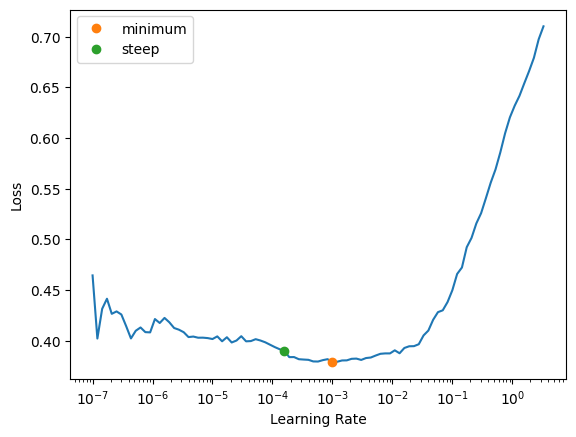

In [13]:
learn = Learner(
    dls, model, loss_func=loss_func, metrics=metrics, cbs=[CSVLogger()]
).to_fp32()

# Choose optimizer and hyperparameters (FastAI will create Adam by default)
# You can override like this:
learn.opt_func = partial(Adam, wd=1e-2)
# Find a good learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print("Suggested LRs:", lr_min, lr_steep)
lr = float(lr_min)
lr

In [14]:
# # Optional: LR finder with capped iterations for small subsets
# lr_min2, lr_steep2 = learn.lr_find(
#     suggest_funcs=(minimum, steep), num_it=min(100, len(dls.train))
# )
# print("Subset-safe Suggested LRs:", lr_min2, lr_steep2)
# # Optionally override lr for training below
# lr = float(lr_min2)
# lr


## Fit One Cycle

In [15]:
learn.fit_one_cycle(EPOCHS, lr)

epoch,train_loss,valid_loss,ccc_v,ccc_a,ccc_avg,mae_v_fe,mae_a_fe,mae_fe,time
0,0.348416,0.332608,0.044314,-0.011384,0.016465,1.517833,1.399069,1.458451,33:31
1,0.326034,0.324372,0.048139,0.014376,0.031257,1.492659,1.369326,1.430992,33:46
2,0.325252,0.325401,0.056116,0.028707,0.042411,1.534320,1.376736,1.455528,33:59
3,0.319573,0.319660,0.059887,0.032989,0.046438,1.509059,1.363762,1.436410,33:57
4,0.330324,0.318802,0.065456,0.037028,0.051242,1.502902,1.361545,1.432223,33:59
5,0.317202,0.317680,0.067757,0.036349,0.052053,1.489501,1.360285,1.424892,33:38
6,0.324554,0.317373,0.068657,0.037527,0.053092,1.496302,1.362809,1.429555,33:36
7,0.325314,0.317455,0.069886,0.037035,0.053461,1.498759,1.360095,1.429427,33:33
8,0.322606,0.317598,0.070006,0.037438,0.053722,1.499938,1.362880,1.431409,33:32
9,0.318482,0.317727,0.070040,0.037416,0.053728,1.502389,1.361525,1.431957,33:32


/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

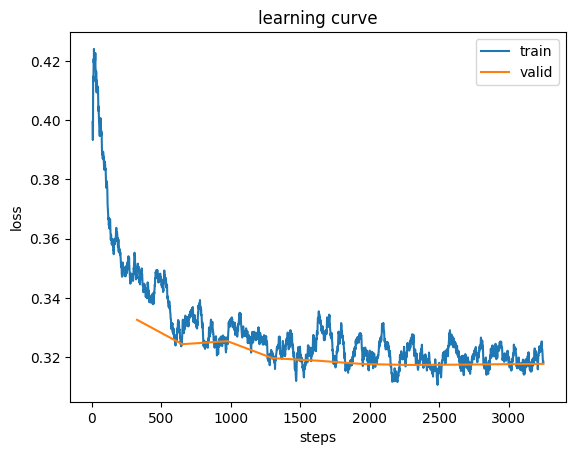

In [16]:
# Plot training/validation loss curves
learn.recorder.plot_loss()


Spearman’s ρ: Only calculated during test evaluation rather than as an epoch metric.

In [17]:
SCALE = 3.0  # both V and A scaled by 3 for bipolar space
SCALE_SQ = SCALE * SCALE  # 9.0


def _resolve_scale() -> float:
    """Return FE→unit scale; prefer SCALE, else sqrt(SCALE_SQ)."""
    try:
        return SCALE  # noqa: F821
    except NameError:
        return math.sqrt(SCALE_SQ)  # noqa: F821


def mae_fe_to_unit(mae_fe):
    """Convert FE-space MAE to ref-space [-1,1] MAE."""
    return float(mae_fe) / _resolve_scale()


In [18]:
mae_fe_to_unit(1.402860)

0.46762

# Evaluate on Test Set

In [19]:
# If your df_test actually contains the target columns:
test_dl = dls.test_dl(df_test, with_labels=True)
test_metrics = learn.validate(dl=test_dl)

names = [
    "test_loss",  # MSE in [-1,1] training space
    "test_ccc_v",
    "test_ccc_a",
    "test_ccc_avg",
    "test_mae_v",
    "test_mae_a",
    "test_mae",  # MAE reported in FE units (see below for per-dim)
]
# Handle None values in metrics
safe_metrics = [float(m) if m is not None else 0.0 for m in test_metrics]
res_basic = dict(zip(names, safe_metrics))

# Full-dataset MAE and Spearman's rho on FE units
preds_ref, targs_ref = learn.get_preds(dl=test_dl)
preds_fe = ref_to_fe(preds_ref.cpu())
targs_fe = ref_to_fe(targs_ref.cpu())

# MAE per-dimension and average
abs_err = torch.abs(preds_fe - targs_fe)
mae_v = abs_err[:, 0].mean().item()
mae_a = abs_err[:, 1].mean().item()
mae_avg = (mae_v + mae_a) / 2.0


def _compute_spearman(x: torch.Tensor, y: torch.Tensor) -> float:
    x = x.detach().cpu().flatten()
    y = y.detach().cpu().flatten()
    try:
        from torchmetrics.functional import spearman_corrcoef as tm_spearman

        val = tm_spearman(x, y)
        return float(val.cpu())
    except Exception:
        pass
    try:
        from scipy.stats import spearmanr

        r = spearmanr(x.numpy(), y.numpy()).correlation
        return float(0.0 if np.isnan(r) else r)
    except Exception:
        pass
    import numpy as np

    def rankdata(a: np.ndarray) -> np.ndarray:
        sorter = np.argsort(a)
        inv = np.empty_like(sorter)
        inv[sorter] = np.arange(len(a))
        a_sorted = a[sorter]
        obs = np.r_[True, a_sorted[1:] != a_sorted[:-1]]
        group = obs.cumsum() - 1
        counts = np.bincount(group)
        cums = np.cumsum(counts)
        starts = cums - counts + 1
        avgranks = (starts + cums) / 2.0
        return avgranks[group][inv]

    xn = x.numpy()
    yn = y.numpy()
    if xn.std() == 0 or yn.std() == 0:
        return 0.0
    rx = rankdata(xn)
    ry = rankdata(yn)
    rx = rx - rx.mean()
    ry = ry - ry.mean()
    denom = np.sqrt((rx**2).sum()) * np.sqrt((ry**2).sum())
    return float(0.0 if denom == 0 else (rx @ ry) / denom)


rho_v = _compute_spearman(preds_fe[:, 0], targs_fe[:, 0])
rho_a = _compute_spearman(preds_fe[:, 1], targs_fe[:, 1])
rho_avg = (rho_v + rho_a) / 2.0

{
    **res_basic,
    "test_mae_v": mae_v,
    "test_mae_a": mae_a,
    "test_mae_avg": mae_avg,
    "test_spearman_v": rho_v,
    "test_spearman_a": rho_a,
    "test_spearman_avg": rho_avg,
}


/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


{'test_loss': 0.3247842490673065,
 'test_ccc_v': nan,
 'test_ccc_a': nan,
 'test_ccc_avg': nan,
 'test_mae_v': 1.5105534791946411,
 'test_mae_a': 1.377847671508789,
 'test_mae': 1.4442006349563599,
 'test_mae_avg': 1.444200575351715,
 'test_spearman_v': 0.19301584362983704,
 'test_spearman_a': 0.1281938999891281,
 'test_spearman_avg': 0.16060487180948257}

**Root cause**: CCC uses Pearson correlation; if predictions or targets have near‑zero variance, CCC’s denominator goes to zero and torchmetrics returns NaN with a warning.  

Above numbers corroborate this: test_loss measured in [-1,1] space scales to FE units by ×9 (since v→3v, a→3a). CCC NaN implies the model’s preds on the test set are (nearly) constant in at least one dim.

## Save head weights (state_dict) and full model if desired


In [20]:
SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)
head_path = SAVE_DIR / "dinov3_baseline_head.pth"
torch.save(model.head.state_dict(), head_path)

# Optionally export the whole fastai Learner
# learn.export(SAVE_DIR/"learner.pkl")

head_path, head_path.exists()


(Path('checkpoints/dinov3_baseline_head.pth'), True)

# Inference helper (returns V,A in FE units)


Using: /Users/desmondchoy/Projects/emo-rec/data/Run_2/Adoring people soccer/6335920-a-quelques-jours-du-coup-d-envoi-du-cham-opengraph_1200-2.jpg


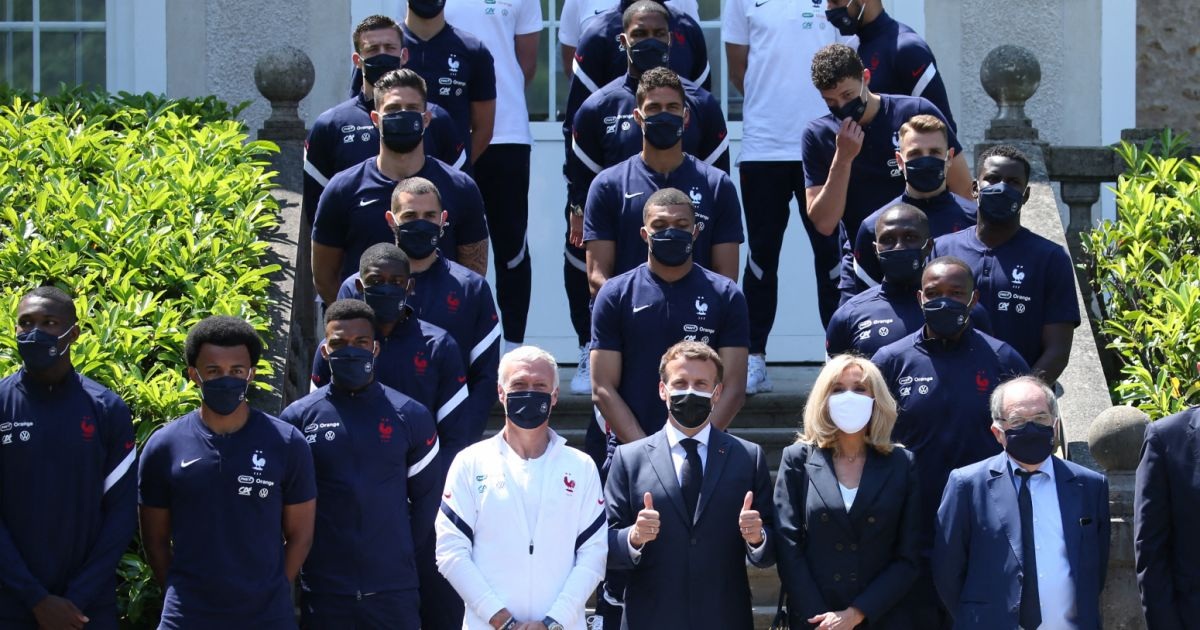

Ground truth (V,A): (0.000, 1.000)
Predicted (V,A): (-1.447, 3.151)


In [21]:
REPO_ROOT = (DATA_ROOT.parent).resolve()  # absolute repo root


def resolve_from_root(p):
    p = Path(p)
    return p if p.is_absolute() else (REPO_ROOT / p)


@torch.inference_mode()
def predict_image(img_path: str | Path):
    img_path = Path(img_path)
    if not img_path.is_absolute():
        img_path = resolve_from_root(img_path)  # resolve exactly once
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = PILImage.create(str(img_path))
    x = HFProcessorTransform(processor, target_size=(W, H))(img)
    x = x.unsqueeze(0).to(device)
    out_ref = model(x)
    out_fe = ref_to_fe(out_ref.cpu())
    return out_fe.squeeze(0)


# Randomly sample one existing test image; show GT and prediction
idxs = list(df_test.index)
random.shuffle(idxs)
for idx in idxs:
    row = df_test.loc[idx]
    p_abs = resolve_from_root(row["image_path"])  # becomes absolute
    if p_abs.exists():
        print("Using:", p_abs)
        # Display the image
        img_disp = PILImage.create(str(p_abs))
        display(img_disp)
        # Display ground-truth V/A
        print(f"Ground truth (V,A): ({row['valence']:.3f}, {row['arousal']:.3f})")
        # Predict and display predicted V/A
        pred_va = predict_image(p_abs)  # predict_image won’t re-resolve absolute paths
        print(f"Predicted (V,A): ({pred_va[0].item():.3f}, {pred_va[1].item():.3f})")
        break
else:
    raise FileNotFoundError("No existing paths found in df_test['image_path'].")


# Export Learner for Inference

In [22]:
# Filter callbacks by type without relying on cbs_of_type (compat-friendly)
csv_cbs = [cb for cb in getattr(learn, "cbs", []) if isinstance(cb, CSVLogger)]
if csv_cbs:
    # Close and detach any file handles before removing
    for cb in csv_cbs:
        f = getattr(cb, "f", None)
        try:
            if f is not None and hasattr(f, "close") and not f.closed:
                f.close()
        except Exception:
            pass
        try:
            if hasattr(cb, "f"):
                delattr(cb, "f")
        except Exception:
            pass
    try:
        learn.remove_cbs(csv_cbs)
    except Exception:
        try:
            learn.cbs = [cb for cb in getattr(learn, "cbs", []) if cb not in csv_cbs]
        except Exception:
            pass

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)
learner_path = SAVE_DIR / "dinov3_baseline_learner.pkl"
learn.export(learner_path)
learner_path, learner_path.exists()


(Path('checkpoints/dinov3_baseline_learner.pkl'), True)

## Load the exported learner and run inference on a single image


Using exported learner on: /Users/desmondchoy/Projects/emo-rec/data/Run_2/Grieving toddlers fighting/image-20160824-30246-8veqk7.jpg


/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


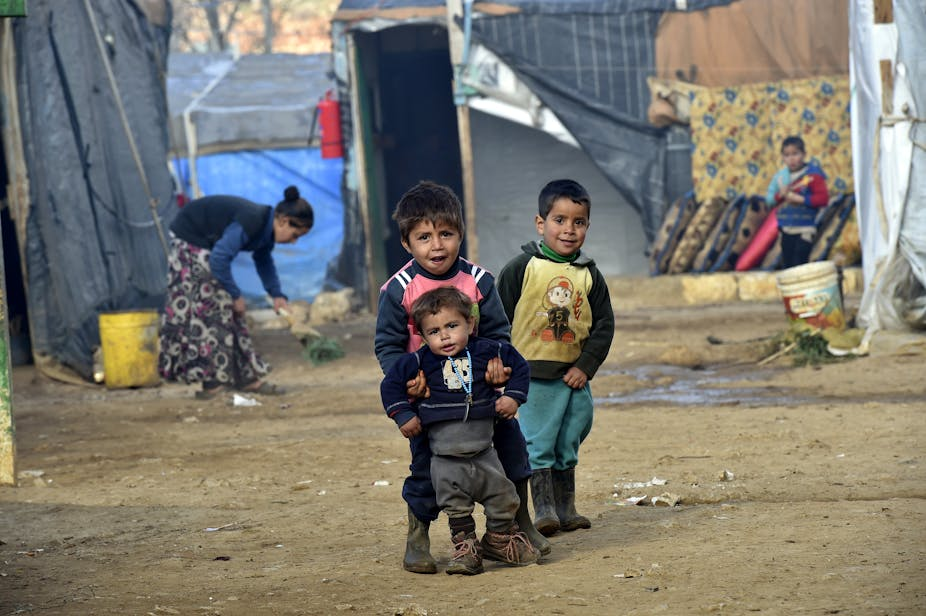

Ground truth (V,A): (2.000, 3.000)


Predicted (V,A): (0.369, 2.962)


In [23]:
learner_path = Path("./checkpoints/dinov3_baseline_learner.pkl")
learn_inf = load_learner(learner_path)  # loads on CPU by default
# Optionally move to GPU if available in this session
try:
    learn_inf.dls.device = device
    learn_inf.model.to(device)
except Exception:
    pass


@torch.inference_mode()
def predict_with_export(img_path: str | Path):
    p = Path(img_path)
    if not p.is_absolute():
        p = resolve_from_root(p)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p}")
    img = PILImage.create(str(p))
    pred_ref, _, _ = learn_inf.predict(img)
    pred_ref_t = torch.as_tensor(pred_ref)
    pred_fe = ref_to_fe(pred_ref_t.unsqueeze(0)).squeeze(0)
    return pred_fe


# Example: randomly sample one existing test image; show GT and prediction
idxs = list(df_test.index)
random.shuffle(idxs)
for idx in idxs:
    row = df_test.loc[idx]
    p_abs = resolve_from_root(row["image_path"])
    if p_abs.exists():
        print("Using exported learner on:", p_abs)
        display(PILImage.create(str(p_abs)))
        print(f"Ground truth (V,A): ({row['valence']:.3f}, {row['arousal']:.3f})")
        pred_va = predict_with_export(p_abs)
        print(f"Predicted (V,A): ({pred_va[0].item():.3f}, {pred_va[1].item():.3f})")
        break
else:
    raise FileNotFoundError("No existing paths found in df_test['image_path'].")
